In [1]:
import random
import json
import urllib.request
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms


In [2]:
def set_seed(seed):
    """Sets the random seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


set_seed(69)

In this project we are using ResNet18 for classfying images

In [3]:
model = models.resnet18(pretrained=True).eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
unnorm = transforms.Normalize(mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])],
                              std=[1/s for s in [0.229, 0.224, 0.225]])


In [5]:
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def get_confidence_interval(image, model):
    with torch.no_grad():

        image_tensor = transform(image).unsqueeze(0)
        output = model(image_tensor)

        probabilities = F.softmax(output, dim=1)

        confidence, predicted_class = torch.max(probabilities, 1)
        confidence_interval = 1.96 * torch.std(probabilities) / torch.sqrt(torch.tensor(probabilities.size(1), dtype=torch.float32))

        return predicted_class.item(), confidence.item(), confidence_interval.item()


In [6]:
#Loading labels of ImageNet

labels = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
filename = "imagenet_classes.txt"
urllib.request.urlretrieve(labels, filename)

with open(filename, "r") as f:
    classes = [line.strip() for line in f.readlines()]



Classifying examples

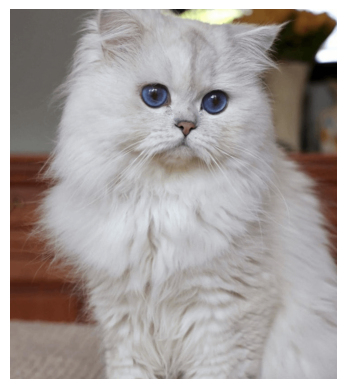

Predicted Label: 283 Persian cat
Confidence: 84.37%
Confidence Interval: ±0.17%


In [7]:
url = "https://preview.redd.it/do-you-prefer-a-silver-pompaws-persian-cat-with-blue-or-v0-o8ltjg7cps7d1.png?width=640&crop=smart&auto=webp&s=98767b43e93199f32cb4f7fe921780b50241438b"
image = load_image_from_url(url)


plt.imshow(image)
plt.axis('off')
plt.show()

# Predicted label and confidence interval
label_pred, confidence, confidence_interval = get_confidence_interval(image, model)

print(f"Predicted Label: {label_pred}", classes[label_pred])
print(f"Confidence: {confidence * 100:.2f}%")
print(f"Confidence Interval: ±{confidence_interval * 100:.2f}%")


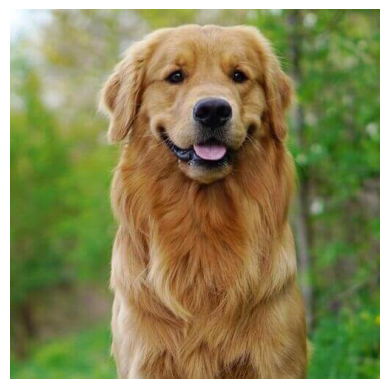

Predicted Label: 207 golden retriever
Confidence: 76.82%
Confidence Interval: ±0.15%


In [8]:
url2 = "https://www.vidavetcare.com/wp-content/uploads/sites/234/2022/04/golden-retriever-dog-breed-info.jpeg"
image2 = load_image_from_url(url2)

plt.imshow(image2)
plt.axis('off')
plt.show()

label_pred, confidence, confidence_interval = get_confidence_interval(image2, model)

print(f"Predicted Label: {label_pred}", classes[label_pred])
print(f"Confidence: {confidence * 100:.2f}%")
print(f"Confidence Interval: ±{confidence_interval * 100:.2f}%")

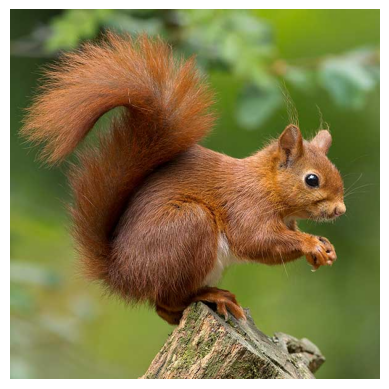

Predicted Label: 335 fox squirrel
Confidence: 97.28%
Confidence Interval: ±0.19%


In [9]:
url3 = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image3 = load_image_from_url(url3)

plt.imshow(image3)
plt.axis('off')
plt.show()

label_pred, confidence, confidence_interval = get_confidence_interval(image3, model)


print(f"Predicted Label: {label_pred}", classes[label_pred])
print(f"Confidence: {confidence * 100:.2f}%")
print(f"Confidence Interval: ±{confidence_interval * 100:.2f}%")

# One pixel attack

A one-pixel attack is a type of adversarial attack where a single pixel in an image is changed to cause a classifier to misclassify the image.

Modifying 1 pixel

In [10]:
def one_pixel_attack(image, model, h, w):

    image_tensor = transform(image).unsqueeze(0)
    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    adv_img_np = img_np.copy()
    adv_img_np[h, w] = [0.0, 0.0, 1.0]

    adv_img_tensor = torch.tensor(adv_img_np).permute(2, 0, 1).float()
    adv_img_tensor = adv_img_tensor / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    adv_img_tensor = adv_img_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    adv_img_tensor = adv_img_tensor.unsqueeze(0)

    plt.imshow(adv_img_np)
    plt.axis('off')
    plt.show()


    with torch.no_grad():
        output = model(adv_img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item()


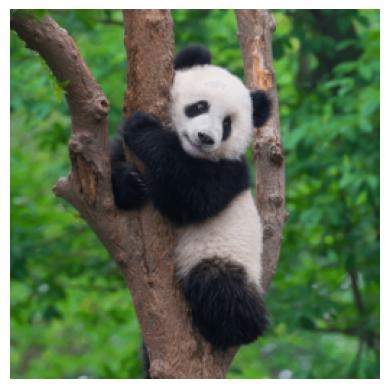

Predicted Label: 388 giant panda
Confidence: 96.98%
Confidence Interval: ±0.19%


In [11]:
image_url1 = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image_url = "https://www.shutterstock.com/image-photo/cute-panda-tree-600nw-201006434.jpg"
image = load_image_from_url(image_url)
image_transformed = transform(image)
image_display = unnorm(image_transformed).permute(1, 2, 0)

plt.imshow(image_display)
plt.axis('off')
plt.show()


label_pred, confidence, confidence_interval = get_confidence_interval(image, model)


print(f"Predicted Label: {label_pred}", classes[label_pred])
print(f"Confidence: {confidence * 100:.2f}%")
print(f"Confidence Interval: ±{confidence_interval * 100:.2f}%")


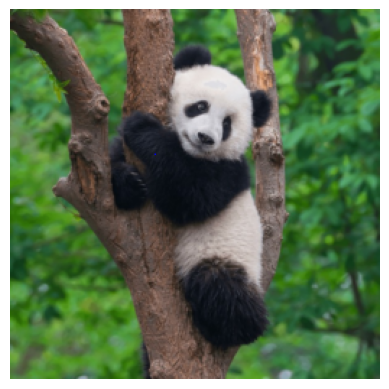

Predicted Label after attack: 368 gibbon
Confidence after attack: 58.68%


In [12]:
h, w = 100, 100
attacked_label_pred, confidence = one_pixel_attack(image, model, h, w)

# Print the results
print(f"Predicted Label after attack: {attacked_label_pred}", classes[attacked_label_pred])
print(f"Confidence after attack: {confidence * 100:.2f}%")

In the previous case we modified a random pixel to fool the model. However, there are techniques to chosse what part of the image to attack to have the best effect.
Here wew use saliency map, to understand which parts of the image are the most important for the model and by attacking them we will fool the classifier.
Saliency Map is an image in which the brightness of a pixel represents how salient the pixel is i.e brightness of a pixel is directly proportional to its saliency. Saliency maps are also called as a heat map where hotness refers to those regions of the image which have a big impact on predicting the class which the object belongs to.

Using saliency map

In [13]:
def get_saliency_map(model, input_tensor, target_class=None):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    model.zero_grad()

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item() if target_class is None else target_class

    output[0, pred_class].backward()
    saliency = input_tensor.grad.data.abs().squeeze().cpu()
    saliency, _ = torch.max(saliency, dim=0)
    return saliency.numpy(), pred_class

def one_pixel_attack_with_saliency(image, model):
    image_tensor = transform(image).unsqueeze(0)

    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    saliency, pred_class = get_saliency_map(model, image_tensor)

    h, w = np.unravel_index(np.argmax(saliency), saliency.shape)

    adv_img_np = img_np.copy()
    adv_img_np[h, w] = [0.0, 0.0, 1.0]

    adv_img_tensor = torch.tensor(adv_img_np).permute(2, 0, 1).float()

    adv_img_tensor = adv_img_tensor / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    adv_img_tensor = adv_img_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    adv_img_tensor = adv_img_tensor.unsqueeze(0)

    plt.imshow(adv_img_np)
    plt.axis('off')
    plt.show()


    with torch.no_grad():
        output = model(adv_img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item(), saliency


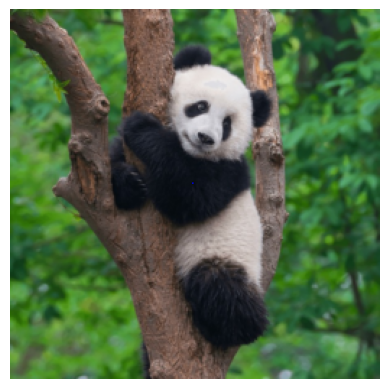

Predicted Label after attack: 368 gibbon
Confidence after attack: 51.85%


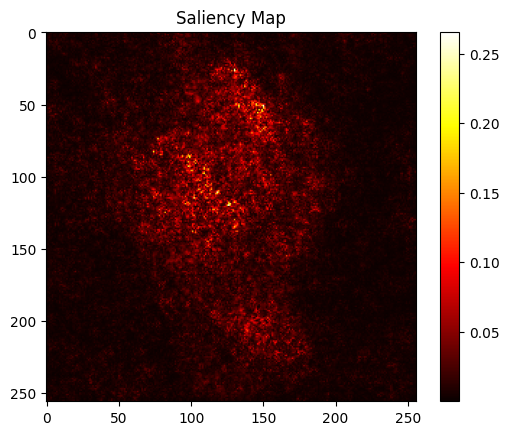

In [14]:
label_pred_sal, confidence, saliency_map = one_pixel_attack_with_saliency(image, model)

print(f"Predicted Label after attack: {label_pred_sal}", classes[label_pred_sal])
print(f"Confidence after attack: {confidence * 100:.2f}%")

plt.imshow(saliency_map, cmap='hot')
plt.title("Saliency Map")
plt.colorbar()
plt.show()

# Multi-pixel attack

ResNet is a quite a strong classifier and not always we can fool it by changing just one pixel. Sometimes we need to attack multiple pixels for the model to misclassify. The techniques below are examples of multiple pixel attacks on both ResNet and a custom weak classifier

In [15]:
def multi_pixel_attack(image, model, num_pixels=2000):

    image_tensor = transform(image).unsqueeze(0)
    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    saliency, pred_class = get_saliency_map(model, image_tensor)

    flat_indices = np.argsort(saliency.ravel())[::-1][:num_pixels]
    coords = [np.unravel_index(idx, saliency.shape) for idx in flat_indices]

    adv_img_multi = img_np.copy()
    for coord in coords:
        adv_img_multi[coord] = [0.3, 0.5, 1.0]

    adv_tensor_multi = transforms.ToTensor()(adv_img_multi).unsqueeze(0)

    adv_tensor_multi = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])(adv_tensor_multi)
    plt.imshow(adv_img_multi)
    plt.title("Multi-Pixel Attack")
    plt.axis('off')
    plt.show()

    with torch.no_grad():
        adv_output_multi = model(adv_tensor_multi)
        adv_class_multi = adv_output_multi.argmax(dim=1).item()

    return adv_class_multi


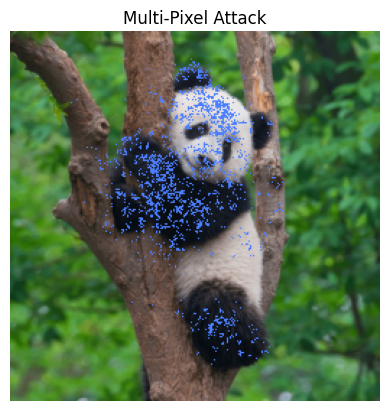

Multi-Pixel Attack Prediction: 17 jay


In [16]:
image_url1 = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image = load_image_from_url(image_url)
adv_class_multi = multi_pixel_attack(image, model, num_pixels=2000)
print("Multi-Pixel Attack Prediction:", adv_class_multi, classes[adv_class_multi])



## Multi pixel attack with saliency map

In [17]:
def multi_pixel_attack_with_saliency(image, model, num_pixels=2000):
    image_tensor = transform(image).unsqueeze(0)

    img_tensor = unnorm(image_tensor.squeeze()).clamp(0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()

    saliency, pred_class = get_saliency_map(model, image_tensor)
    saliency_flat = saliency.flatten()
    top_indices = np.argsort(saliency_flat)[-num_pixels:]

    height, width = saliency.shape
    top_pixels = [(i // width, i % width) for i in top_indices]

    adv_img_np = img_np.copy()
    for h, w in top_pixels:
        adv_img_np[h, w] = [0.0, 0.0, 0.0]

    adv_img_tensor = torch.tensor(adv_img_np).permute(2, 0, 1).float()

    adv_img_tensor = adv_img_tensor / torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    adv_img_tensor = adv_img_tensor - torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    adv_img_tensor = adv_img_tensor.unsqueeze(0)

    plt.imshow(adv_img_np)
    plt.axis('off')
    plt.show()

    with torch.no_grad():
        output = model(adv_img_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), confidence.item(), saliency


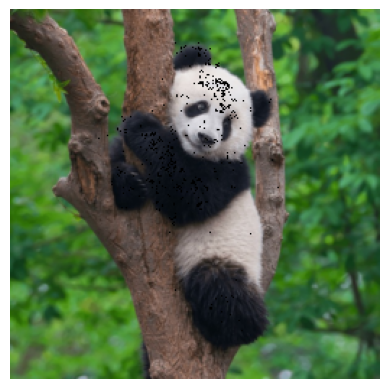

Predicted Label after attack: 388 indri
Confidence after attack: 39.89%


In [18]:
image_url1 = "https://www.flapest.com/wp-content/uploads/2020/12/fox-squirrel.jpg"
image = load_image_from_url(image_url)

label_pred_multi, confidence, saliency_map = multi_pixel_attack_with_saliency(image, model, num_pixels=500)

print(f"Predicted Label after attack: {label_pred}", classes[label_pred_multi])
print(f"Confidence after attack: {confidence * 100:.2f}%")


# Multi pixel attack using Homemade classifier on MNIST dataset


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


True Label: 5


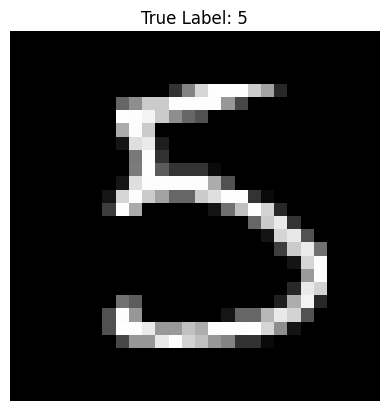

In [20]:
# MNIST transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load test set
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
img_tensor, label = test_data[15]
input_tensor = img_tensor.unsqueeze(0)
print("True Label:", label)

# Show the image
plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()


In [21]:
class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


In [22]:
# Load MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

model = HomemadeCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

model.train()
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}] complete!")

print("Training complete!")


Epoch [1/5] complete!
Epoch [2/5] complete!
Epoch [3/5] complete!
Epoch [4/5] complete!
Epoch [5/5] complete!
Training complete!


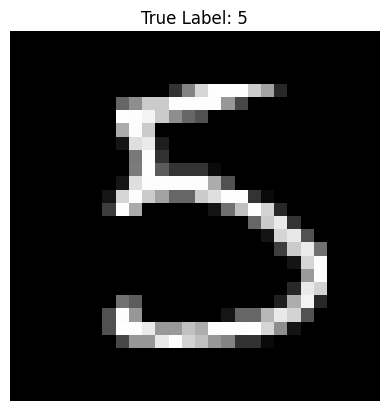

True Label: 5, Predicted: 5


In [23]:
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
img_tensor, label = test_data[15]
input_tensor = img_tensor.unsqueeze(0)

plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()

input_tensor = input_tensor.to(device)

model.eval()
with torch.no_grad():
    pred = model(input_tensor).argmax(dim=1).item()
print(f"True Label: {label}, Predicted: {pred}")

In [24]:
gray_img = img_tensor.squeeze().numpy()
flat = gray_img.flatten()
brightest_indices = np.argsort(flat)[-55:]
coords = [np.unravel_index(idx, (28, 28)) for idx in brightest_indices]

adv_gray_img = gray_img.copy()
for h, w in coords:
    adv_gray_img[h, w] = 0.0


adv_gray_tensor = torch.tensor(adv_gray_img).unsqueeze(0).unsqueeze(0).float().to(device)


In [25]:
model.eval()

HomemadeCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [26]:
with torch.no_grad():
    pred = model(adv_gray_tensor).argmax(dim=1).item()
    print("Prediction after attack:", pred)

Prediction after attack: 3


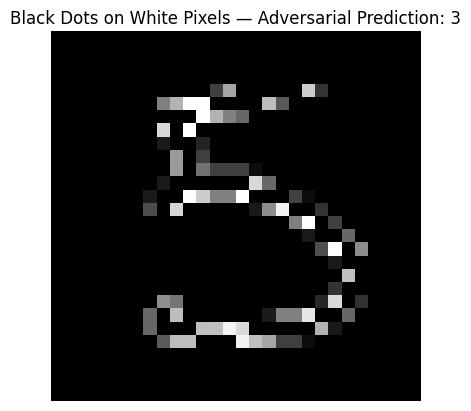

In [27]:
with torch.no_grad():
    adv_pred = model(adv_gray_tensor).argmax(dim=1).item()

plt.imshow(adv_gray_img, cmap='gray')
plt.title(f"Adversarial Prediction: {adv_pred}")
plt.axis('off')
plt.show()